In [1]:
import numpy as np
import matplotlib.pyplot as plt
import AtmosphericBlocking
import sys
%matplotlib inline

In [2]:
alpha=0.55
tau = 10*86400.0

In [3]:
def gaussforce(x,t,peak=2,inject=True):
    tc = 12.3
    tw = 2.5
    t = t/86400.0
    xc = 16800.0e3
    xw = 2800.0e3
    sx = 1.852e-5 + np.zeros(len(x))
    if inject:
        sx *= (1+peak*np.exp(-((x-xc)/xw)**2 - ((t-tc)/tw)**2))
    return sx
    

In [4]:
def noforce(x,t,peak=None,inject=None):
    sx = np.zeros(len(x))
    return sx

In [5]:
def xtsinforce(x,t,peak=None,inject=None):
    sx = 2.0e-5 + 2.0e-5*np.sin(2*np.pi*x/x[-1]-np.pi/6.0)*np.sin(2*np.pi*t/(4.0*86400.0))
    return sx

In [6]:
def xsinforce(x,t,peak=None,inject=None):
    sx = 2.0e-5 + 2.0e-5*np.sin(2*np.pi*x/x[-1]-np.pi/6.0)
    return sx

In [7]:
def noboru_cx(x,Lx,alpha):
    A0 = 10*(1-np.cos(4*np.pi*x/Lx))
    cx = 60 - 2*alpha*A0
    return cx,A0

In [8]:
model = AtmosphericBlocking.Model(nx=2048,Lx = 28000e3,dt=.001*86400,alpha=alpha,
                                        tmax=3.5*86400,D=3.26e5,tau=tau,
                                        sfunc=gaussforce,cfunc=noboru_cx,
                                        forcingpeak=4,injection=True)

In [9]:
tmaxes = np.linspace(1,70,500)*86400

In [10]:
A = 0
S = 0
F = 0
sat = 0
ua = 0
for tmax in tmaxes:

    model.tmax = tmax
    model.run()

    try:
        A = np.vstack([A,model.A[np.newaxis]])
        F = np.vstack([F,((model.C-alpha*model.A)*model.A)[np.newaxis]])
        sat = np.vstack([sat,((4*alpha*(model.C-alpha*model.A)*model.A)/model.C**2)[np.newaxis]])
        S = np.vstack([S,model.S[np.newaxis]])
        ua = np.vstack([ua,(40-alpha*(model.A+model.A0))[np.newaxis]])
    except:
        A = model.A
        S = model.S
        F = (model.C-alpha*model.A)*model.A
        sat = (4*alpha*(model.C-alpha*model.A)*model.A)/model.C**2
        ua = 40-alpha*(model.A+model.A0)
        

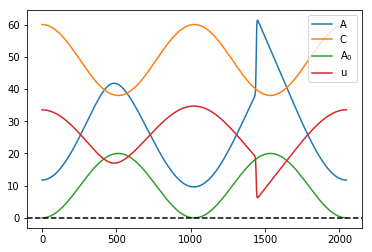

In [11]:
plt.plot(A[115,:]+model.A0,label='A')
plt.plot(model.C,label='C')
plt.plot(model.A0,label='A$_0$')
plt.plot(40-alpha*(A[115,:]+model.A0),label='u')
#plt.plot((model.C-alpha*A[115,:]),label='C-$\\alpha$A')
plt.legend()
plt.axhline(0,linestyle='--',label='0 m/s',color='k')

In [ ]:
dx = model.x[2]-model.x[1]
for t in range(0,350):
    fig,axes=plt.subplots(2,figsize=(5,10))
    axes[0].plot(A[t,:]+model.A0,label='A')
    axes[0].plot(model.A0,label='A$_0$')
    axes[0].set_title("A")
    axes[0].set_ylim(0,100)
    axes[0].set_xlim(0,len(model.A0))
    axes[0].plot(S[t,:]*.001*86400,label='Forcing')
    axes[0].legend()
    axes[1].plot(F[t,:])
    axes[1].set_title("F")
    axes[1].set_ylim(0.9*(np.amin(F)),1.02*(np.amax(F)))
    axes[1].set_xlim(0,len(model.A0))
    plt.savefig("flux_evolution%03d.png"%t,bbox_inches='tight')
    plt.close('all')

In [12]:
lons = model.x/1e3*360/28000. + 100.0
lons[np.where(lons>180)] -= 360.0

In [13]:
print(A.shape,ua.shape)

(500, 2048) (500, 2048)


Text(0.5,1,'A')

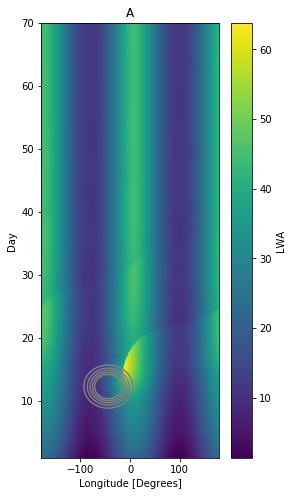

In [14]:
plt.figure(figsize=(4.,8))
plt.pcolormesh(np.roll(lons,-456),tmaxes/86400,np.roll(A+model.A0[np.newaxis,:],-456),shading='Gouraud')
plt.colorbar(label="LWA")
plt.contour(np.roll(lons,-456),tmaxes/86400,np.roll(S,-456),np.linspace(3e-5,6e-5,5),colors='0.5')
plt.xlabel(r"Longitude [Degrees]")
plt.ylabel(r"Day")
plt.title("A")
#plt.ylim(5,30)
#plt.xlim(-100,100)
#plt.xlim(13500,model.Lx/1e3)

Text(0.5,1,'F')

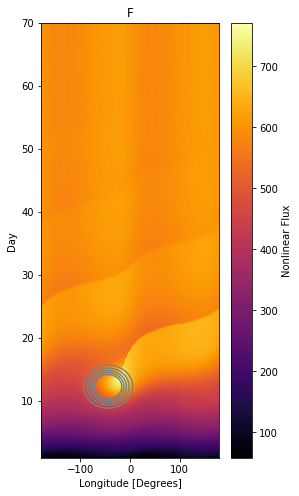

In [15]:
plt.figure(figsize=(4.,8))
plt.pcolormesh(np.roll(lons,-456),tmaxes/86400,np.roll(F,-456),shading='Gouraud',cmap='inferno')
plt.colorbar(label='Nonlinear Flux')
plt.contour(np.roll(lons,-456),tmaxes/86400,np.roll(S,-456),np.linspace(3e-5,6e-5,5),colors='0.5')
plt.xlabel(r"Longitude [Degrees]")
plt.ylabel(r"Day")
plt.title("F")
#plt.ylim(5,30)
#plt.xlim(-100,100)
#plt.xlim(13500,model.Lx/1e3)

(-100, 100)

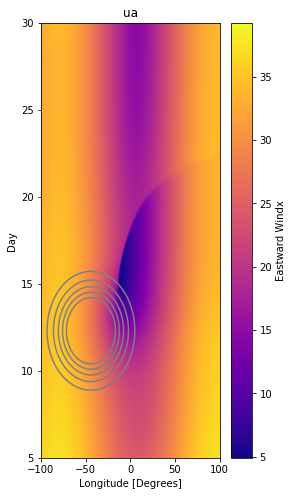

In [16]:
plt.figure(figsize=(4.,8))
plt.pcolormesh(np.roll(lons,-456),tmaxes/86400,np.roll(ua,-456),shading='Gouraud',cmap='plasma')
plt.colorbar(label='Eastward Windx')
plt.contour(np.roll(lons,-456),tmaxes/86400,np.roll(S,-456),np.linspace(3e-5,6e-5,5),colors='0.5')
plt.xlabel(r"Longitude [Degrees]")
plt.ylabel(r"Day")
plt.title("ua")
plt.ylim(5,30)
plt.xlim(-100,100)
#plt.xlim(13500,model.Lx/1e3)

(-100, 100)

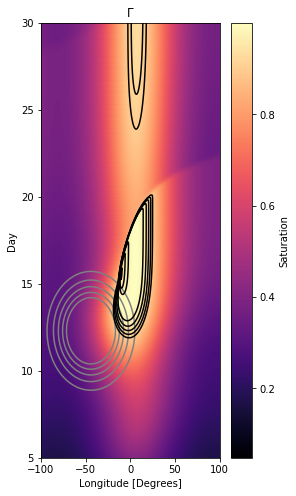

In [17]:
plt.figure(figsize=(4.,8))
plt.pcolormesh(np.roll(lons,-456),tmaxes/86400,np.roll(sat,-456),shading='Gouraud',cmap='magma')
plt.colorbar(label='Saturation')
plt.contour(np.roll(lons,-456),tmaxes/86400,np.roll(S,-456),np.linspace(3e-5,6e-5,5),colors='0.5')
plt.contour(np.roll(lons,-456),tmaxes/86400,np.roll(sat,-456),(0.90,0.92,0.94,0.96,0.98,1.0),colors=('k','k','k','k','k','g'))
plt.xlabel(r"Longitude [Degrees]")
plt.ylabel(r"Day")
plt.title("$\Gamma$")
plt.ylim(5,30)
plt.xlim(-100,100)
#plt.xlim(13500,model.Lx/1e3)

In [18]:
def trajectory(t0,times,cx,xx):
    traj = []
    ttimes = []
    x0 = xx[0]
    posx = x0
    it0 = np.where(times>=t0)[0][0]
    ttimes.append(t0)
    dt = 0.01*86400.0
    traj.append(posx)
    while posx < np.amax(xx) and ttimes[-1]<times[-1]:
        #dt = times[it0+1]-times[it0]
        vx = np.interp(posx,xx,cx)
        posx += vx*dt
        ttimes.append(ttimes[-1]+dt)
        traj.append(posx)
        it0+=1
    return np.array(ttimes),np.array(traj)

In [19]:
def trajectory_ua(t0,times,ua,xx):
    traj = []
    ttimes = []
    x0 = xx[0]
    posx = x0
    it0 = np.where(times>=t0)[0][0]
    ttimes.append(times[it0])
    traj.append(posx)
    while posx < np.amax(xx) and ttimes[-1]<times[-1]:
        dt = times[it0+1]-times[it0]
        vx = np.interp(posx,xx,0.5*(ua[it0,:]+ua[it0+1,:])) #Leapfrog
        posx += vx*dt
        ttimes.append(ttimes[-1]+dt)
        traj.append(posx)
        it0+=1
    return np.array(ttimes),np.array(traj)

(3500, 28000.0)

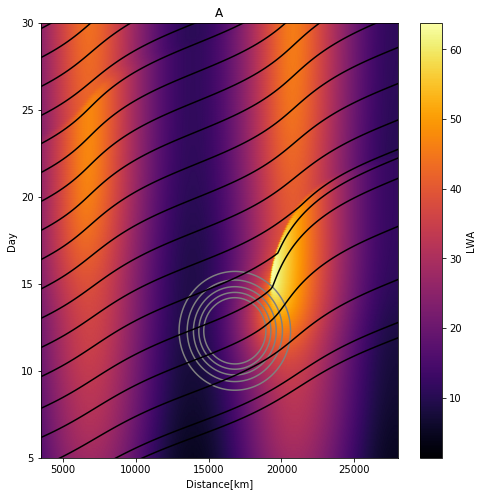

In [20]:
plt.figure(figsize=(8.,8))
plt.pcolormesh(model.x/1.0e3,tmaxes/86400,A+model.A0[np.newaxis,:],cmap='inferno',shading='Gouraud')
plt.colorbar(label='LWA')
plt.contour(model.x/1.0e3,tmaxes/86400,S,np.linspace(3e-5,6e-5,5),colors='0.5')
for t0 in np.linspace(0.*86400.0,65.*86400.0,num=40):
    tt,tx = trajectory_ua(t0,tmaxes,ua,model.x)
    plt.plot(tx/1.0e3,tt/86400.0,color='k')
plt.xlabel(r"Distance[km]")
plt.ylabel(r"Day")
plt.title("A")
plt.ylim(5,30)
plt.xlim(3500,model.Lx/1e3)

(13500, 28000.0)

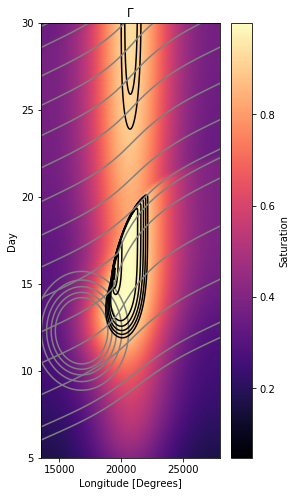

In [24]:
plt.figure(figsize=(4.,8))
plt.pcolormesh(model.x/1.0e3,tmaxes/86400,sat,shading='Gouraud',cmap='magma')
plt.colorbar(label='Saturation')
plt.contour(model.x/1.0e3,tmaxes/86400,S,np.linspace(3e-5,6e-5,5),colors='0.5')
for t0 in np.linspace(0.*86400.0,65.*86400.0,num=40):
    tt,tx = trajectory_ua(t0,tmaxes,ua,model.x)
    plt.plot(tx/1.0e3,tt/86400.0,color='gray')
plt.contour(model.x/1.0e3,tmaxes/86400,sat,(0.90,0.92,0.94,0.96,0.98,1.0),colors=('k','k','k','k','k','g'))
plt.xlabel(r"Longitude [Degrees]")
plt.ylabel(r"Day")
plt.title("$\Gamma$")
plt.ylim(5,30)
plt.xlim(13500,model.Lx/1e3)

(13500, 28000.0)

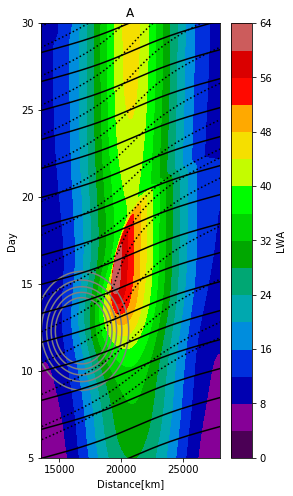

In [22]:
plt.figure(figsize=(4.,8))
plt.contourf(model.x/1.0e3,tmaxes/86400,A+model.A0[np.newaxis,:],15,cmap='nipy_spectral')
plt.colorbar(label='LWA')
plt.contour(model.x/1.0e3,tmaxes/86400,S,np.linspace(3e-5,6e-5,5),colors='0.5')
for t0 in np.linspace(0.*86400.0,65.*86400.0,num=40):
    tt,tx = trajectory(t0,tmaxes,model.C,model.x)
    plt.plot(tx/1.0e3,tt/86400.0,color='k')
for t0 in np.linspace(0.*86400.0,65.*86400.0,num=40):
    tt,tx = trajectory_ua(t0,tmaxes,ua,model.x)
    plt.plot(tx/1.0e3,tt/86400.0,color='k',linestyle=':')
plt.xlabel(r"Distance[km]")
plt.ylabel(r"Day")
plt.title("A")
plt.ylim(5,30)
plt.xlim(13500,model.Lx/1e3)